# AI FOR SECURITY

In [23]:
## Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

import os

## DATASET

### Download Dataset

Create the directory and download the whole CSV dataset through *wget*
```bash
mkdir dataset
cd dataset/ && wget -c -r -np -nH --cut-dirs=3 -R "index.html*" http://205.174.165.80/IOTDataset/CICIoMT2024/Dataset/WiFI_and_MQTT/attacks/CSV/
```

### Analyse Dataset

#### Plot length of each file

In [17]:
def get_color_by_length(length):
    if length < 20000:
        return 'green'
    elif length < 100000:
        return 'orange'
    else:
        return 'red'

def plot_len(name, directory_type="original"):
    # Base directory selection
    if directory_type.lower() == "original":
        base_dir = 'dataset/original'
        dir_suffix = "_og"
    elif directory_type.lower() == "subset":
        base_dir = 'dataset/subset'
        dir_suffix = ""
    else:
        raise ValueError("directory_type must be either 'original' or 'subset'")
    
    # Construct directory path
    data_dir = os.path.join(base_dir, name + dir_suffix)
    
    # Check if directory exists
    if not os.path.exists(data_dir):
        print(f"Directory not found: {data_dir}")
        return
    
    files = os.listdir(data_dir)
    
    # Dictionary to store file names and their lengths
    file_lengths = {}
    
    # Get length of each CSV file
    total_rows = 0
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(data_dir, file)
            df = pd.read_csv(file_path)
            length = len(df)
            file_lengths[file] = length
            total_rows += length
    
    if not file_lengths:
        print(f"No CSV files found in {data_dir}")
        return
    
    # Create a bar plot
    plt.figure(figsize=(15, 8))
    
    # Create bars with colors based on length
    bars = plt.bar(file_lengths.keys(), file_lengths.values())
    
    # Set color for each bar based on its height
    if directory_type.lower() == "original":
        for bar in bars:
            bar.set_color(get_color_by_length(bar.get_height()))
    
    # Customize the plot
    plt.title(f'Number of Rows in Each CSV File - {name} Dataset ({directory_type})', pad=20)
    plt.xlabel('File Names')
    plt.ylabel('Number of Rows')
    
    # Add legend
    if directory_type.lower() == "original":
        legend_elements = [plt.Rectangle((0,0),1,1, facecolor='green', label='<20k rows'),
                            plt.Rectangle((0,0),1,1, facecolor='orange', label='20k-100k rows'),
                            plt.Rectangle((0,0),1,1, facecolor='red', label='>100k rows')]
        plt.legend(handles=legend_elements)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on top of each bar
    #for bar in bars:
    #    height = bar.get_height()
    #    plt.text(bar.get_x() + bar.get_width()/2., height,
    #            f'{int(height):,}',
    #            ha='center', va='bottom')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'file_lengths_{name}_{directory_type}.png', bbox_inches='tight')
    print(f"\nPlot saved as file_lengths_{name}_{directory_type}.png")
    
    # Display the plot
    plt.show()

def compare_directories(name):
    print(f"\nAnalyzing {name} dataset in both original and subset directories...")
    plot_len(name, "original")
    plot_len(name, "subset")



Plot saved as file_lengths_train_original.png


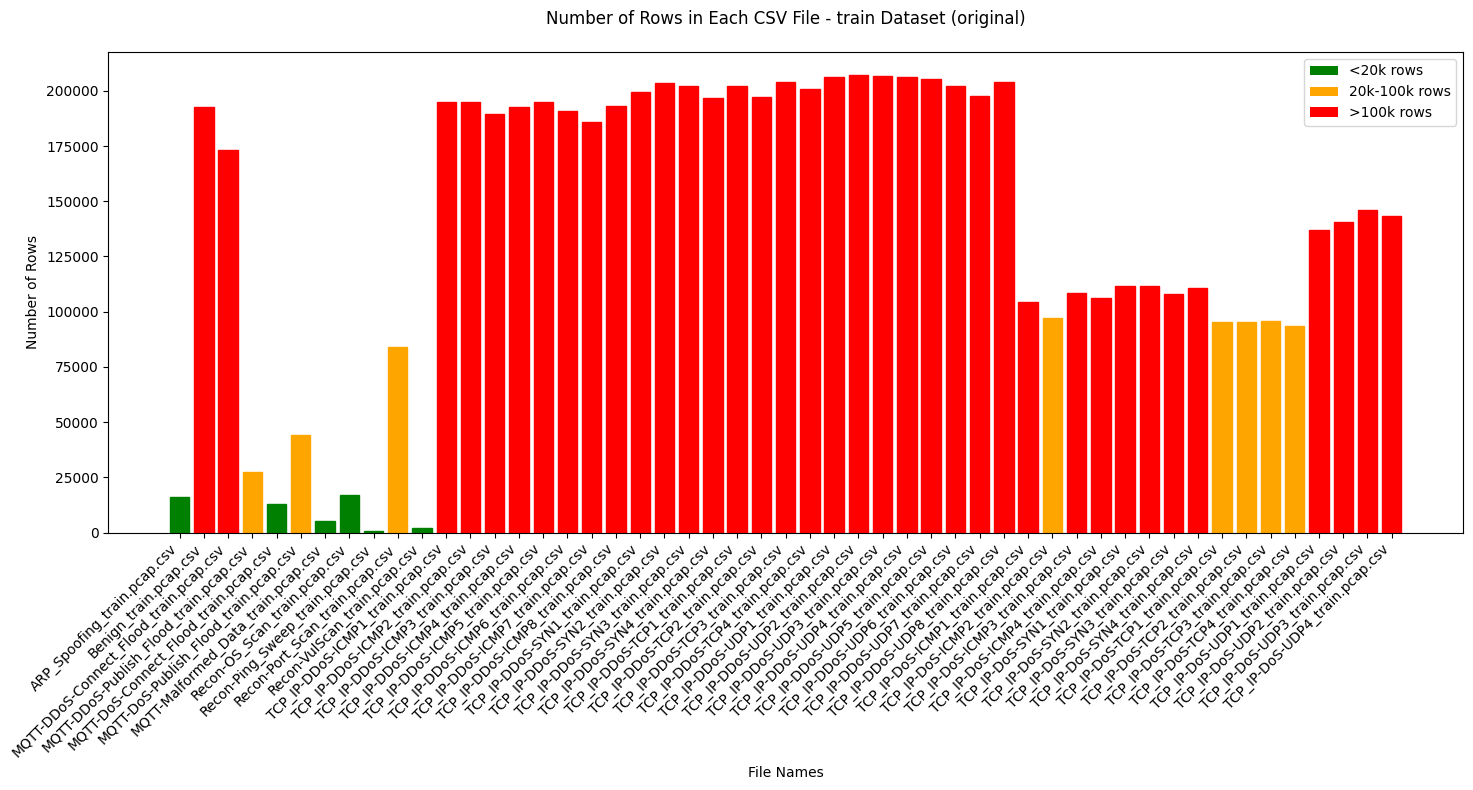


Plot saved as file_lengths_test_original.png


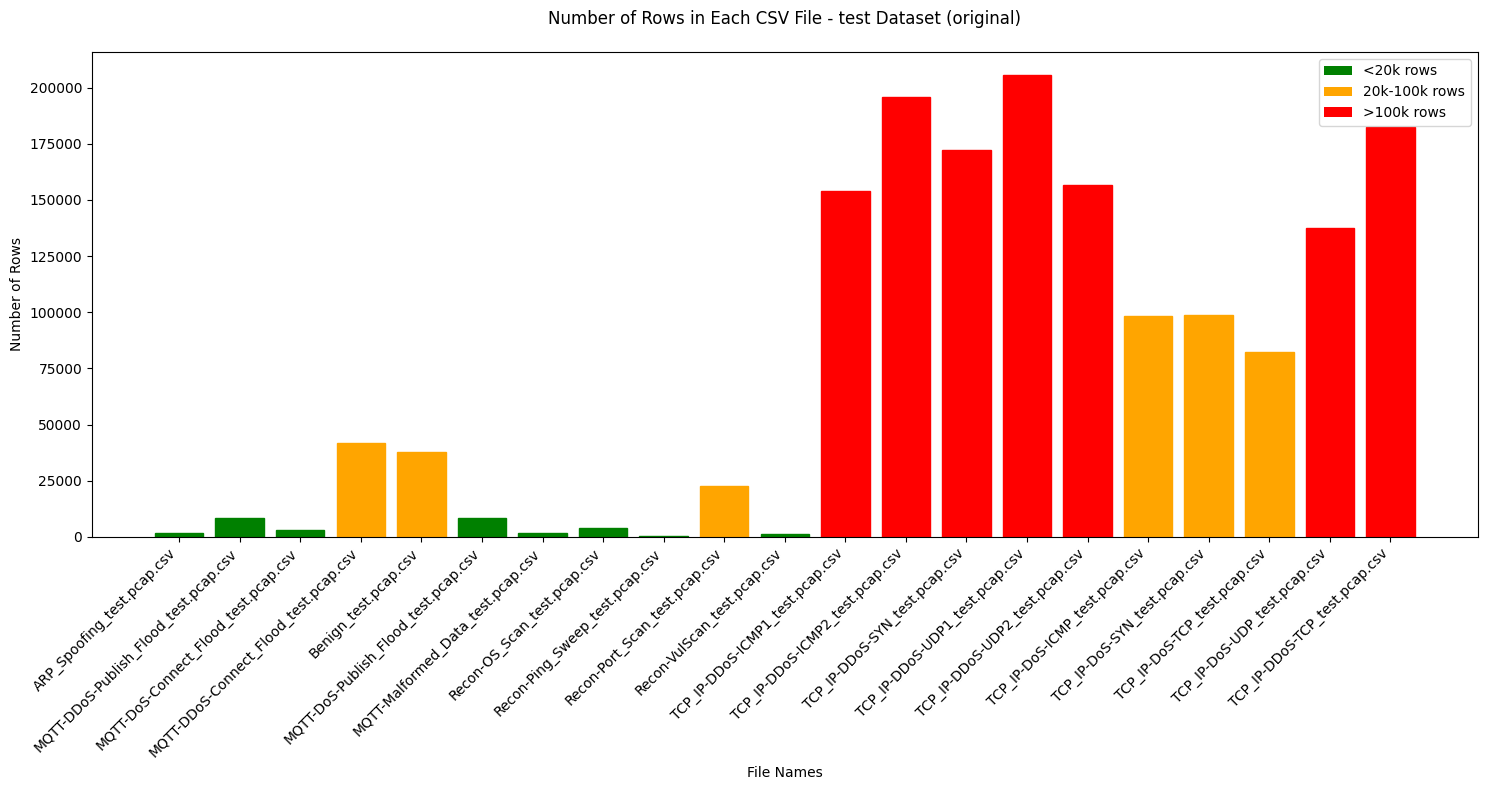

In [18]:
plot_len("train", "original")
plot_len("test", "original")

#### Create Subset

**Create the directory** 
```bash
mkdir dataset/subset && cd dataset/subset
mkdir train && mkdir test
```

Create an incremental subset of each csv file

In [ ]:
RANDOM_SEED = 42

CAP = 20000
FIRST = 0.2
SECOND = 0.1

# List all files in the original dataset directory
original_dir = 'dataset/original'
subset_dir = 'dataset/subset'

def calculate_subset(df):
    total_rows = len(df)
    
    if total_rows < CAP:
        # For files under 20k rows, keep all rows
        return df
    
    elif total_rows < 100000:
        # For files between 20k and 100k:
        # 1. First 20k random rows
        first = df.sample(n=CAP, random_state=RANDOM_SEED)
        
        # 2. 20% of remaining rows
        remaining_rows = df.drop(first.index)
        additional_rows = remaining_rows.sample(frac=FIRST, random_state=RANDOM_SEED)
        
        # Combine both samples
        return pd.concat([first, additional_rows])
    
    else:
        # For files over 100k:
        # 1. First 20k random rows
        first = df.sample(n=CAP, random_state=RANDOM_SEED)
        
        # 2. 20% of next 80k rows
        next_80k = df.drop(first.index).sample(n=(100000-CAP), random_state=RANDOM_SEED)
        twenty_percent_of_80k = next_80k.sample(frac=0.2, random_state=RANDOM_SEED)
        
        # 3. 10% of remaining rows (those above 100k)
        remaining_rows = df.drop(first.index).drop(next_80k.index)
        ten_percent_of_remaining = remaining_rows.sample(frac=0.1, random_state=RANDOM_SEED)
        
        # Combine all samples
        return pd.concat([first, twenty_percent_of_80k, ten_percent_of_remaining])

def subset(name):
    np.random.seed(RANDOM_SEED)
    og_dir = os.path.join(original_dir, name + "_og")
    sub_dir = os.path.join(subset_dir, name)
    
    # Print the directory being processed
    print(f"Processing directory: {og_dir}")
    
    # Make sure the output directory exists
    os.makedirs(sub_dir, exist_ok=True)
    
    # List of all files
    files = os.listdir(og_dir)
    
    for file in files:
        file_path = os.path.join(og_dir, file)
        if os.path.isfile(file_path) and file.endswith('.csv'):
            # Read the CSV file
            df = pd.read_csv(file_path)
            original_size = len(df)
            
            # Calculate subset based on size
            df_subset = calculate_subset(df)
            
            # Save the subset to the new directory
            subset_file_path = os.path.join(sub_dir, file)
            df_subset.to_csv(subset_file_path, index=False)
            
            print_processed_info = lambda file, original_size, subset_size: print(
                f"Processed {file}:\n"
                f"  Original size: {original_size:,} rows\n"
                f"  Subset size: {subset_size:,} rows\n"
                f"  Reduction: {((original_size - subset_size) / original_size * 100):.1f}%\n"
            )
            #print_processed_info(file, original_size, len(df_subset))
    
    print(f"Finished processing {name} directory\n")

# Process both train and test datasets
subset("train")
subset("test")

Processing directory: dataset/original/train_og
Finished processing train directory

Processing directory: dataset/original/test_og
Finished processing test directory



**Merging the test and training files together**

In [24]:
def get_category_and_attack(filename):
    # Dictionary mapping regex patterns to categories and specific attacks
    attack_mapping = {
        r'^Benign': ('BENIGN', '-'),
        r'^ARP_Spoofing': ('SPOOFING', 'ARP Spoofing'),
        r'^Recon-Ping_Sweep': ('RECON', 'Ping Sweep'),
        r'^Recon-VulScan': ('RECON', 'Recon VulScan'),
        r'^Recon-OS_Scan': ('RECON', 'OS Scan'),
        r'^Recon-Port_Scan': ('RECON', 'Port Scan'),
        r'^MQTT-Malformed_Data': ('MQTT', 'Malformed Data'),
        r'^MQTT-DoS-Connect_Flood': ('MQTT', 'DoS Connect Flood'),
        r'^MQTT-DDoS-Publish_Flood': ('MQTT', 'DDoS Publish Flood'),
        r'^MQTT-DoS-Publish_Flood': ('MQTT', 'DoS Publish Flood'),
        r'^MQTT-DDoS-Connect_Flood': ('MQTT', 'DDoS Connect Flood'),
        r'TCP_IP-DoS-TCP': ('DoS', 'DoS TCP'),
        r'TCP_IP-DoS-ICMP': ('DoS', 'DoS ICMP'),
        r'TCP_IP-DoS-SYN': ('DoS', 'DoS SYN'),
        r'TCP_IP-DoS-UDP': ('DoS', 'DoS UDP'),
        r'TCP_IP-DDoS-SYN': ('DDoS', 'DDoS SYN'),
        r'TCP_IP-DDoS-TCP': ('DDoS', 'DDoS TCP'),
        r'TCP_IP-DDoS-ICMP': ('DDoS', 'DDoS ICMP'),
        r'TCP_IP-DDoS-UDP': ('DDoS', 'DDoS UDP')
    }
    
    for pattern, (category, attack) in attack_mapping.items():
        if re.match(pattern, filename):
            return category, attack
            
    return 'UNKNOWN', 'UNKNOWN'

def merge_csv_files(directory, output_file):
    # List to store all dataframes
    dfs = []
    
    # Walk through all files in directory
    files = os.listdir(directory)
    total_files = len(files)
    
    print(f"Processing {total_files} files in {directory}")
    
    for i, filename in enumerate(files, 1):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            
            # Get category and attack type
            category, attack = get_category_and_attack(filename)
            
            # Read the CSV
            df = pd.read_csv(file_path)
            
            # Add category and attack columns
            df['category'] = category
            df['attack'] = attack
            
            dfs.append(df)
            
            print(f"Processed file {i}/{total_files}: {filename} - Category: {category}, Attack: {attack}")
    
    # Concatenate all dataframes
    print("\nMerging all dataframes...")
    merged_df = pd.concat(dfs, ignore_index=True)
    
    # Save to file
    print(f"Saving merged dataset to {output_file}")
    merged_df.to_csv(output_file, index=False)
    
    # Print summary
    print("\nSummary of merged dataset:")
    print(f"Total rows: {len(merged_df)}")
    print("\nDistribution of attacks:")
    summary = merged_df.groupby(['category', 'attack']).size().reset_index(name='count')
    summary = summary.sort_values('count', ascending=False)
    print(summary)

# Merge train and test separately
base_dir = 'dataset/subset'
merge_csv_files(os.path.join(base_dir, 'train'), 'merged_train.csv')
merge_csv_files(os.path.join(base_dir, 'test'), 'merged_test.csv')

Processing 51 files in dataset/subset/train
Processed file 1/51: ARP_Spoofing_train.pcap.csv - Category: SPOOFING, Attack: ARP Spoofing
Processed file 2/51: Benign_train.pcap.csv - Category: BENIGN, Attack: -
Processed file 3/51: MQTT-DDoS-Connect_Flood_train.pcap.csv - Category: MQTT, Attack: DDoS Connect Flood
Processed file 4/51: MQTT-DDoS-Publish_Flood_train.pcap.csv - Category: MQTT, Attack: DDoS Publish Flood
Processed file 5/51: MQTT-DoS-Connect_Flood_train.pcap.csv - Category: MQTT, Attack: DoS Connect Flood
Processed file 6/51: MQTT-DoS-Publish_Flood_train.pcap.csv - Category: MQTT, Attack: DoS Publish Flood
Processed file 7/51: MQTT-Malformed_Data_train.pcap.csv - Category: MQTT, Attack: Malformed Data
Processed file 8/51: Recon-OS_Scan_train.pcap.csv - Category: RECON, Attack: OS Scan
Processed file 9/51: Recon-Ping_Sweep_train.pcap.csv - Category: RECON, Attack: Ping Sweep
Processed file 10/51: Recon-Port_Scan_train.pcap.csv - Category: RECON, Attack: Port Scan
Processed fi

### Plotting


Plot saved as file_lengths_test_subset.png


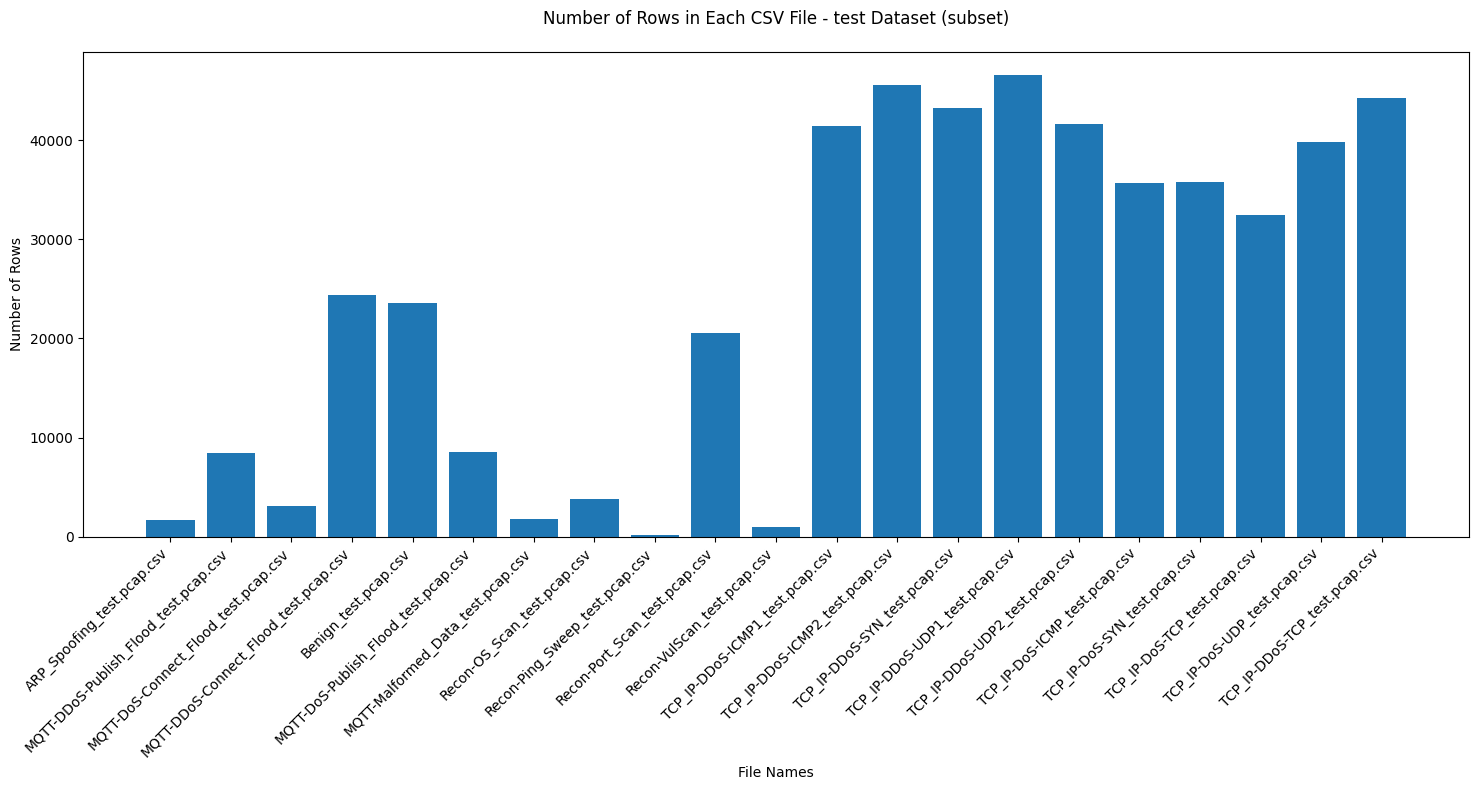


Analyzing train dataset in both original and subset directories...

Plot saved as file_lengths_train_original.png


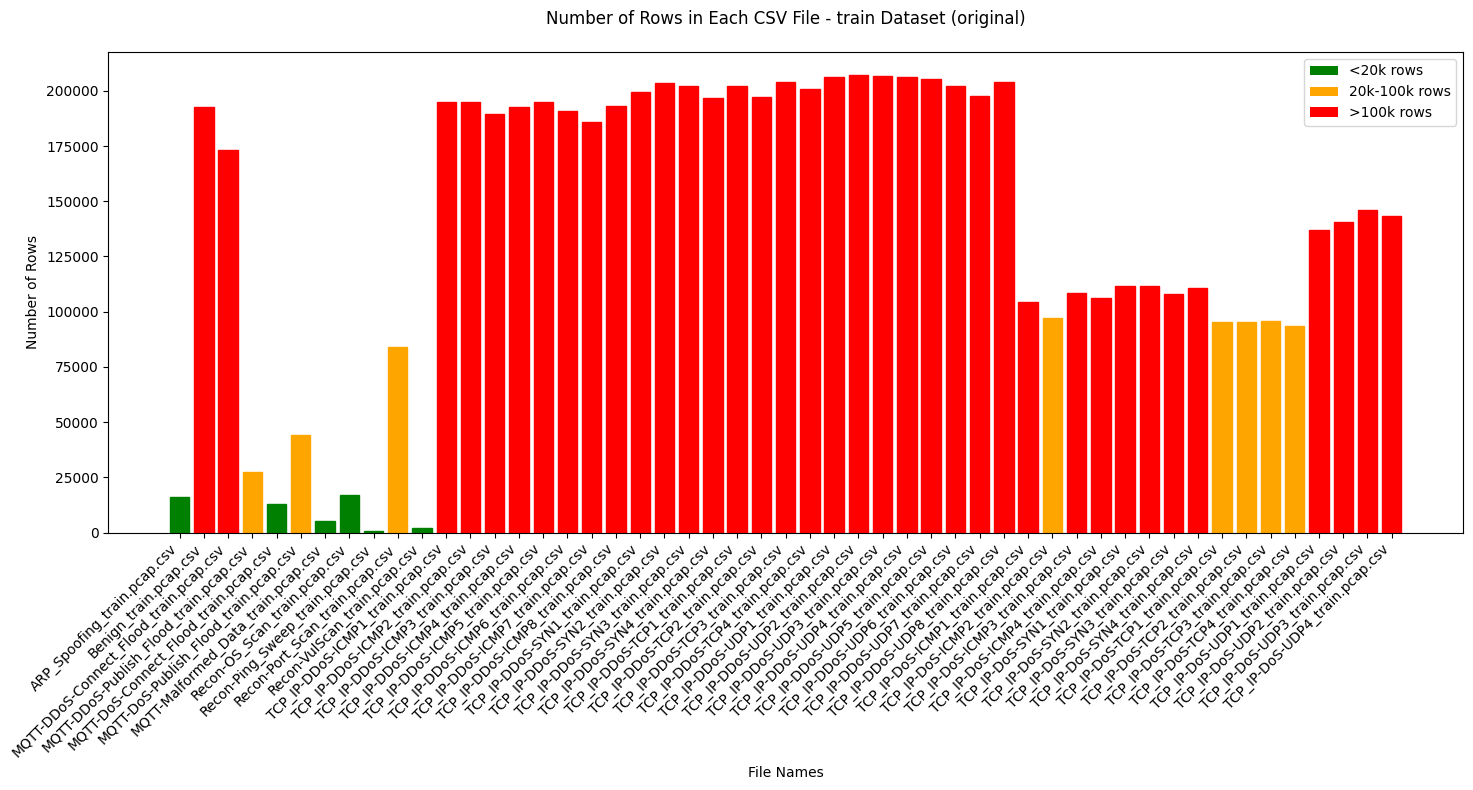


Plot saved as file_lengths_train_subset.png


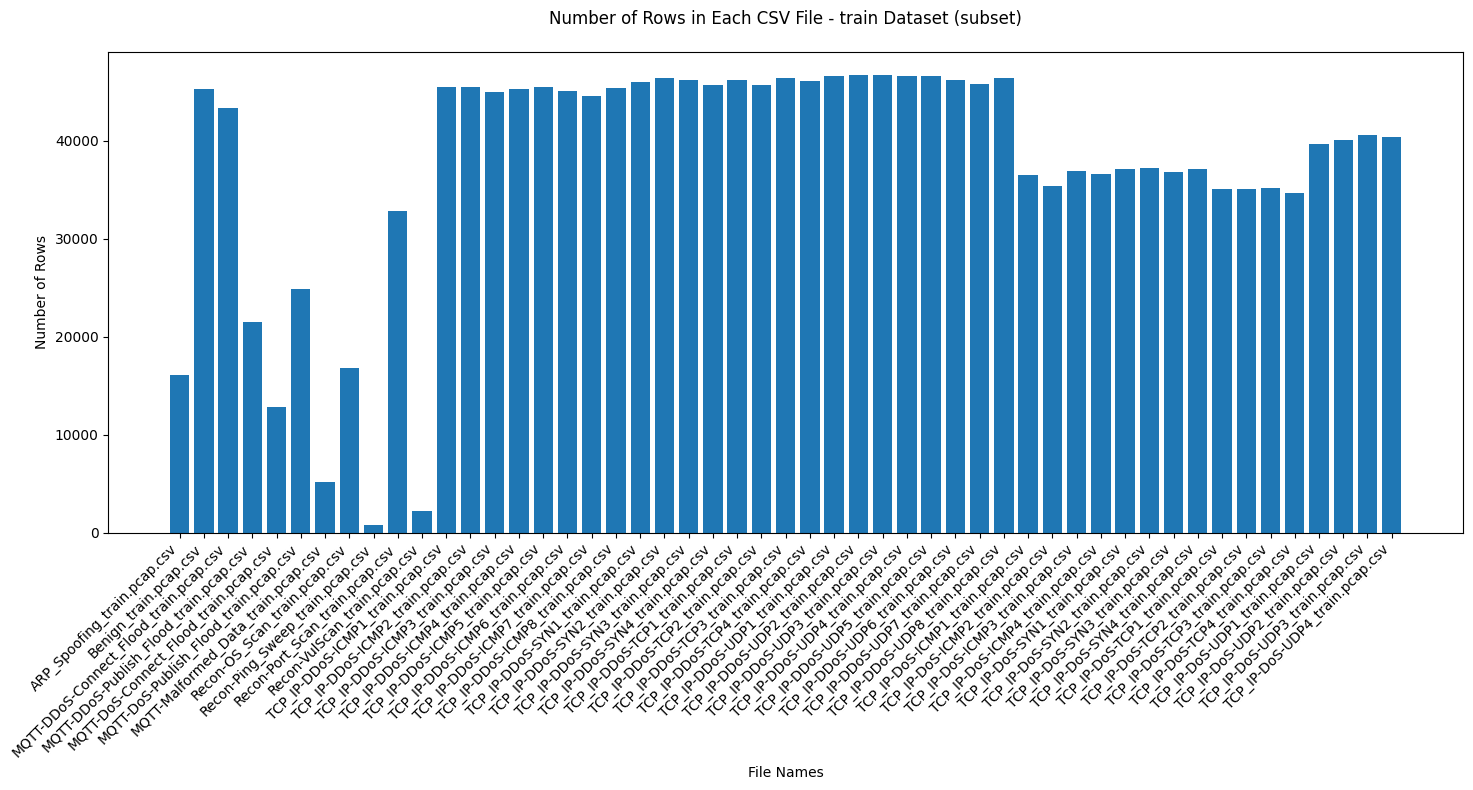

In [20]:
plot_len("test", "subset")
compare_directories("train")